In [1]:
from pypfopt import expected_returns, EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt, BlackLittermanModel, black_litterman
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import *
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta

In [2]:
cutoff_date = date.today() - relativedelta(years = 2)

In [3]:
tickers = ['AAPL', 'AEE', 'AIG', 'BIIB', 'CNC', 'DLTR', 'DPZ', 'DVA', 'KR', 'NEM']
prices = yf.download(tickers, period = '10y' , progress = False)['Close'].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,AAPL,AEE,AIG,BIIB,CNC,DLTR,DPZ,DVA,KR,NEM
Date,,,,,,,,,,
2015-04-13,28.329119,30.692537,44.952282,423.359985,35.174999,81.820000,90.005821,81.760002,31.417433,17.836325
2015-04-14,28.206285,30.854959,44.983562,423.570007,35.000000,81.050003,88.469788,82.010002,30.960550,18.033890
2015-04-15,28.313480,30.825432,45.585957,430.959991,33.895000,81.209999,88.353027,81.610001,30.421354,18.610783
2015-04-16,28.177254,30.507959,45.499908,428.649994,34.650002,81.029999,90.212425,82.129997,30.199085,18.666105
2015-04-17,27.860132,30.367670,44.928810,419.440002,34.075001,79.139999,89.143478,81.260002,29.569340,18.626585
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,181.460007,94.339996,77.559998,119.190002,61.349998,72.839996,436.570007,146.610001,66.459999,44.860001
2025-04-08,172.419998,94.230003,77.669998,114.050003,62.400002,69.699997,430.720001,143.919998,66.370003,44.959999
2025-04-09,198.850006,96.349998,82.820000,120.489998,62.630001,72.570000,456.350006,152.860001,65.830002,48.750000


In [4]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [5]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,AAPL,AEE,AIG,BIIB,CNC,DLTR,DPZ,DVA,KR,NEM
Date,,,,,,,,,,
2015-04-14,-0.004336,0.005292,0.000696,0.000496,-0.004975,-0.009411,-0.017066,0.003058,-0.014542,0.011077
2015-04-15,0.003800,-0.000957,0.013391,0.017447,-0.031571,0.001974,-0.001320,-0.004877,-0.017416,0.031989
2015-04-16,-0.004811,-0.010299,-0.001888,-0.005360,0.022275,-0.002216,0.021045,0.006372,-0.007306,0.002973
2015-04-17,-0.011255,-0.004598,-0.012552,-0.021486,-0.016595,-0.023325,-0.011849,-0.010593,-0.020853,-0.002117
2015-04-20,0.022845,0.012643,0.001393,0.008297,0.024358,0.007202,0.004233,0.007138,-0.007795,-0.002121
...,...,...,...,...,...,...,...,...,...,...
2023-04-05,-0.011290,0.033098,0.007419,0.031753,0.028290,-0.001276,-0.001793,0.016671,-0.028306,0.014021
2023-04-06,0.005496,0.008962,0.016720,0.009895,0.003496,0.002286,0.006700,-0.005667,0.009571,-0.000384
2023-04-10,-0.015972,-0.000666,0.000587,-0.013738,0.004544,0.026100,-0.002632,0.002789,0.007832,-0.018444


<Axes: xlabel='Ticker', ylabel='Ticker'>

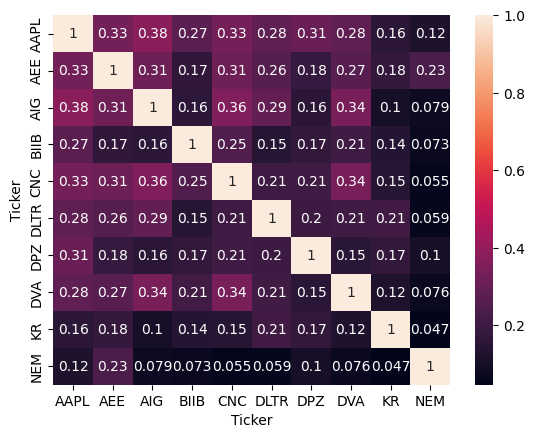

In [6]:
sns.heatmap(returns_train.corr(), annot = True)

In [7]:
spy_prices = yf.download('SPY', progress = False)['Close'].dropna()

mcaps = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_cap = stock.info.get("marketCap")
    mcaps[ticker] = market_cap
    
mcaps

{'AAPL': 2976629129216,
 'AEE': 26348511232,
 'AIG': 47851872256,
 'BIIB': 16858009600,
 'CNC': 31678392320,
 'DLTR': 15509636096,
 'DPZ': 15851044864,
 'DVA': 12440799232,
 'KR': 45086191616,
 'NEM': 61965484032}

Classic Mean-Variance

OrderedDict({'AAPL': 0.4092147774892761, 'AEE': 0.2834076470293548, 'AIG': 0.0, 'BIIB': 0.0, 'CNC': 0.0, 'DLTR': 0.0, 'DPZ': 0.2065171371342732, 'DVA': 0.0, 'KR': 0.0, 'NEM': 0.1008604383470958})


<Axes: xlabel='Weight'>

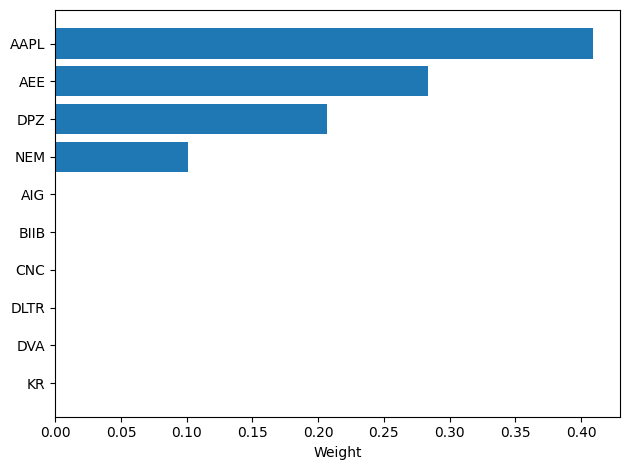

In [8]:
mu_classic = expected_returns.mean_historical_return(prices_train)
S_classic = sample_cov(prices_train)

ef_classic = EfficientFrontier(mu_classic, S_classic)
weights_classic = ef_classic.max_sharpe()
print(weights_classic)
plot_weights(weights_classic)

Robuse Mean-Variance (shrinkage)

<Axes: xlabel='Weight'>

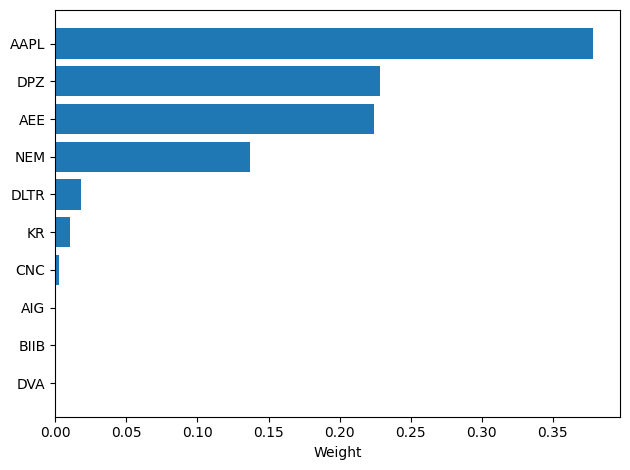

In [9]:
mu_shrink = expected_returns.mean_historical_return(prices_train)
S_shrink = CovarianceShrinkage(prices_train).shrunk_covariance(delta = 0.4)

ef_shrink = EfficientFrontier(mu_shrink, S_shrink)
weights_shrink = ef_shrink.max_sharpe()
plot_weights(weights_shrink)

Robust Mean-Variance (ledoit wolf)

<Axes: xlabel='Weight'>

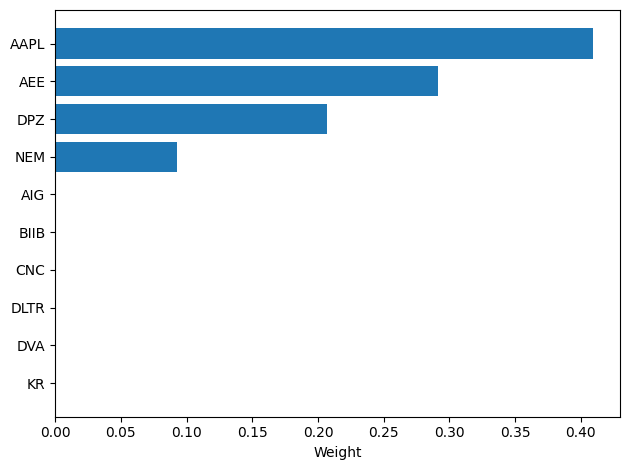

In [10]:
mu_ledoit = expected_returns.mean_historical_return(prices_train)
S_ledoit = CovarianceShrinkage(prices_train).ledoit_wolf('constant_correlation')

ef_ledoit = EfficientFrontier(mu_ledoit, S_ledoit)
weights_ledoit = ef_ledoit.max_sharpe()
plot_weights(weights_ledoit)

Efficient CVaR

In [11]:
mu_cvar = expected_returns.mean_historical_return(prices_train)
historical_returns_cvar = expected_returns.returns_from_prices(prices_train)

ef_cvar = EfficientCVaR(mu_cvar, historical_returns_cvar)
ef_cvar.min_cvar()

# We can use the same helper methods as before
weights_cvar = ef_cvar.clean_weights()
print(weights_cvar)
print(ef_cvar.portfolio_performance(verbose=True))

OrderedDict({'AAPL': 0.0, 'AEE': 0.32, 'AIG': 0.0, 'BIIB': 0.05799, 'CNC': 0.04749, 'DLTR': 0.02672, 'DPZ': 0.16684, 'DVA': 0.10889, 'KR': 0.14846, 'NEM': 0.12362})
Expected annual return: 9.8%
Conditional Value at Risk: 2.29%
(np.float64(0.09800430563246662), np.float64(0.02287675988836259))


Hierarchical risk parity

OrderedDict({'AAPL': np.float64(0.07178321713565035), 'AEE': np.float64(0.18901926253662008), 'AIG': np.float64(0.05387267096410021), 'BIIB': np.float64(0.061257604083476545), 'CNC': np.float64(0.06724664438050422), 'DLTR': np.float64(0.0892388432510909), 'DPZ': np.float64(0.1127758110792333), 'DVA': np.float64(0.09517552139662107), 'KR': np.float64(0.15366058633374888), 'NEM': np.float64(0.10596983883895442)})
Expected annual return: 13.8%
Annual volatility: 16.5%
Sharpe Ratio: 0.84


<Axes: >

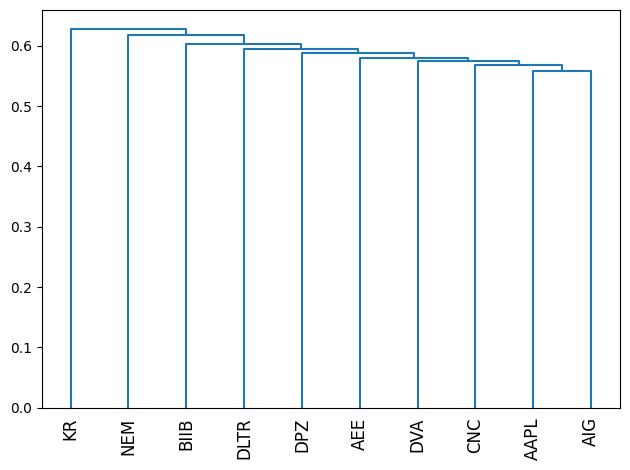

In [12]:
hrp = HRPOpt(returns_train)
weights_hrp = hrp.optimize()
print(weights_hrp)
hrp.portfolio_performance(verbose=True)
plot_dendrogram(hrp)

Black-Litterman model

In [13]:
mu_bl = expected_returns.mean_historical_return(prices_train)
S_bl = sample_cov(prices_train)
delta = black_litterman.market_implied_risk_aversion(spy_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S_bl)

In [14]:
[0] * len(tickers)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
returns_train.columns

Index(['AAPL', 'AEE', 'AIG', 'BIIB', 'CNC', 'DLTR', 'DPZ', 'DVA', 'KR', 'NEM'], dtype='object', name='Ticker')

In [16]:
views = np.array([0.1786, -0.0018, 0.0008, 0.3908, 0.3242, 0.2785, 0.0941, 0.0861, 0.1360, 0.0031]).reshape(-1, 1)
picking = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    ]
)

bl = BlackLittermanModel(S_bl, Q=views, P=picking, pi=prior, tau=0.02)
rets_bl = bl.bl_returns()
ef_bl = EfficientFrontier(rets_bl, S_bl)
weights_bl = ef_bl.max_sharpe()
print(ef_bl.clean_weights())
ef_bl.portfolio_performance(verbose=True)

OrderedDict({'AAPL': 0.44273, 'AEE': 0.0, 'AIG': 0.0, 'BIIB': 0.1526, 'CNC': 0.15621, 'DLTR': 0.15953, 'DPZ': 0.0, 'DVA': 0.0, 'KR': 0.08893, 'NEM': 0.0})
Expected annual return: 21.5%
Annual volatility: 22.4%
Sharpe Ratio: 0.96


(np.float64(0.21532045512339684),
 np.float64(0.22407051004600673),
 np.float64(0.9609495469938757))

<Axes: xlabel='Weight'>

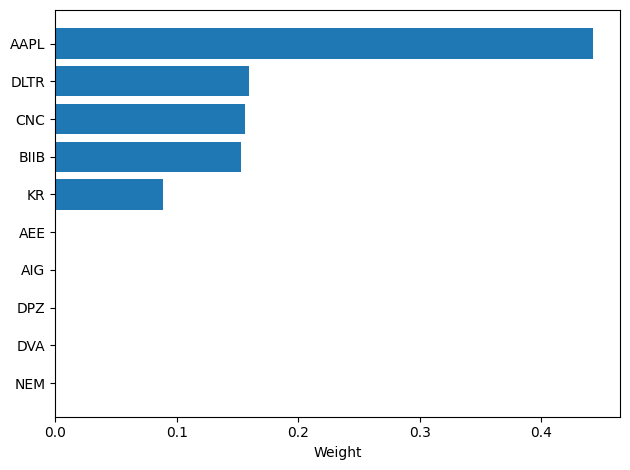

In [17]:
plot_weights(weights_bl)

In [18]:
in_sample = {
    'MV': sum(returns_train[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_train[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_train[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_train[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_train[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_train[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns, title = 'Cumulative returns (in-sample)')

In [19]:
px.line(in_sample_drawdowns, title = 'Drawdowns (in-sample)')

In [20]:
in_sample_returns.std().sort_values().map('{:.3%}'.format)

Mean-CVaR           1.038%
HRP                 1.041%
Shrunk (d = 0.4)    1.213%
MV                  1.234%
Ledoit              1.234%
Black-Litterman     1.412%
dtype: object

In [21]:
in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Shrunk (d = 0.4)    -25.793%
MV                  -25.328%
Ledoit              -25.244%
Black-Litterman     -24.917%
Mean-CVaR           -23.396%
HRP                 -21.666%
dtype: object

In [22]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
in_sample_cagr.sort_values().map('{:.2%}'.format)

HRP                 13.25%
Mean-CVaR           13.31%
Black-Litterman     16.19%
Shrunk (d = 0.4)    20.92%
Ledoit              21.04%
MV                  21.07%
dtype: object

In [23]:
weights = {
    'MV': weights_classic,
    'Ledoit (constant correlation)': weights_ledoit,
    'Shrunk (d = 0.4)': weights_shrink,
    'Mean-CVaR': weights_cvar,
    'Black-Litterman': weights_bl,
    'HRP': weights_hrp
}

weights = pd.DataFrame(weights)
weights_long = weights.T.reset_index().melt(id_vars='index', var_name='Stock Ticker', value_name='Weight')

fig = px.bar(weights_long, 
             x='index', 
             y='Weight', 
             color='Stock Ticker', 
             barmode='stack',
             title='Portfolio Weights by Optimization Method',
             labels={'index': 'Optimization Method', 'Weight': 'Portfolio Weight', 'Stock Ticker': 'Stock'},
             text='Weight'
             )

fig.update_traces(texttemplate='%{text:.1%}', textposition='inside')
fig.show()

In [24]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,AAPL,AEE,AIG,BIIB,CNC,DLTR,DPZ,DVA,KR,NEM
Date,,,,,,,,,,
2023-04-13,0.034103,0.001445,0.005846,0.013681,0.032450,-0.008590,0.018870,0.013327,-0.005706,0.026353
2023-04-14,-0.002114,-0.007103,-0.003487,-0.005419,-0.018599,-0.006583,-0.006675,-0.005213,-0.008501,-0.029400
2023-04-17,0.000121,0.003130,0.009331,0.014126,0.009255,-0.008249,-0.001453,-0.001191,0.024866,-0.021203
2023-04-18,0.007505,-0.016158,0.010401,0.005578,0.003348,0.018408,-0.009700,-0.004412,0.000837,0.008046
2023-04-19,0.006968,0.011326,0.013534,-0.005309,-0.031191,-0.005958,-0.003183,0.001318,-0.008359,-0.012280
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,-0.036734,-0.015137,-0.017606,-0.030818,-0.009365,0.078312,-0.017199,-0.019266,-0.010717,0.015392
2025-04-08,-0.049818,-0.001166,0.001418,-0.043124,0.017115,-0.043108,-0.013400,-0.018348,-0.001354,0.002229
2025-04-09,0.153289,0.022498,0.066306,0.056466,0.003686,0.041177,0.059505,0.062118,-0.008136,0.084297


In [25]:
out_of_sample = {
    'MV': sum(returns_test[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_test[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_test[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_test[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_test[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_test[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns, title = 'Cumulative returns (out-of-sample)')

In [26]:
px.line(out_of_sample_drawdowns, title = 'Drawdowns (out-of-sample)')

In [27]:
out_of_sample_returns.std().sort_values().map('{:.3%}'.format)

HRP                 0.856%
Mean-CVaR           0.911%
Ledoit              1.048%
MV                  1.052%
Shrunk (d = 0.4)    1.060%
Black-Litterman     1.088%
dtype: object

In [28]:
out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Black-Litterman     -23.768%
Ledoit              -16.053%
MV                  -15.958%
Shrunk (d = 0.4)    -15.197%
Mean-CVaR           -13.206%
HRP                 -13.121%
dtype: object

In [29]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
out_of_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman     -3.54%
HRP                 10.12%
Mean-CVaR           12.66%
Shrunk (d = 0.4)    14.16%
Ledoit              14.42%
MV                  14.45%
dtype: object